# Análise de Sentimentos com Rede Neural no *Large Movie Review Dataset*

---

Terceiro projeto de PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

Autor: Enzo Bustos da Silva

*Large Movie Review Dataset:*
* [Kaggle](https://www.kaggle.com/c/sentiment-analysis-pmr3508/data)
* [Stanford](https://ai.stanford.edu/~amaas/data/sentiment/)

Nesse notebook vamos discutir um pouco a respeito da aplicação de Redes Neurais (MLPs) para a identificação se os sentimentos transmitidos pelos textos de avaliações de filmes do site IMDb são positivos ou negativos.

Para a realização desse projeto deveremos aplicar o modelo pré-treinado de doc2vec para realizar o pré-processamento e transformação dos textos em vetores. Após isso deveremos usar grid ou random search para achar o número ótimo de neurônios para as 2 redes que treinaremos, uma com apenas 1 hidden layer e a segunda com 2 hidden layers, usando a implementação disponível no [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

Após isso faremos novamente uma Rede Neural contendo 2 camadas ocultas, mas dessa vez utilizando as implementações do keras, após isso validaremos nossos modelos com um conjunto de teste e enviaremos nossas predições para o kaggle utilizando um conjunto de dados de validação.

De maneira opcional o professor achou válido utilizar outros modelos de machine learning que não se baseiam em MLPs e, eu farei essa parte como um complemento para testar também esses outros modelos, bem como a performance deles utilizando as curvas ROC e AUC.

In [1]:
!pip install ftfy
!pip install gensim

# Limpeza dos dados e análise exploratória:

---

Nosso conjunto de dados consiste em uma série de avaliações de filmes e também da classificação do sentimento dela em positivo ou negativo, parece muito mais simples, mas essa parte provavelmente será uma das mais diferentes dos outros EP's, de qualquer forma eu acho que é muito necessário termos uma visualização dos nossos dados de forma a ter o *feeling* sobre o que estamos lidando.

Vamos primeiramente aplicar uma função de limpeza pelos nossos dados (disponibilizada no Moodle) para assim remover tudo que não for uma letra, retirar as tag HTML, tokenizar nossos dados, remover stopwords e aplicar lematização (pegar a raiz de palavras derivadas), vamos para o código:

In [2]:
# Primeiro vamos carregar algumas bibliotecas e importar nossos dados

from google.colab import drive
drive.mount('/content/drive', force_remount=1)

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/Poli/Aprendizado de Máquina/EPs/EP3 - Rede Neural/Conjunto de Dados'

/content/drive/MyDrive/Poli/Aprendizado de Máquina/EPs/EP3 - Rede Neural/Conjunto de Dados


In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')
df.head(10)

,review,positive
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
5,"This isn't the comedic Robin Williams, nor is ...",1
6,Yes its an art... to successfully make a slow ...,1
7,"In this ""critically acclaimed psychological th...",1
8,THE NIGHT LISTENER (2006) **1/2 Robin Williams...,1
9,"You know, Robin Williams, God bless him, is co...",1


Primeiro de tudo, vamos remover os nossos dados duplicados

In [5]:
df = df.drop_duplicates(subset='review', keep='first')

Nossos dados consistem de 2 colunas, uma com o texto da review de um filme e o segundo parâmetro significa se a review é positiva (True = 1) ou se ela é negativa (False = 0). Vamos instanciar nosso X_train e y_train e ver um desses textos como exemplo.

In [6]:
X_train = df['review']
y_train = df['positive']

X_train[5]

"This isn't the comedic Robin Williams, nor is it the quirky/insane Robin Williams of recent thriller fame. This is a hybrid of the classic drama without over-dramatization, mixed with Robin's new love of the thriller. But this isn't a thriller, per se. This is more a mystery/suspense vehicle through which Williams attempts to locate a sick boy and his keeper.<br /><br />Also starring Sandra Oh and Rory Culkin, this Suspense Drama plays pretty much like a news report, until William's character gets close to achieving his goal.<br /><br />I must say that I was highly entertained, though this movie fails to teach, guide, inspect, or amuse. It felt more like I was watching a guy (Williams), as he was actually performing the actions, from a third person perspective. In other words, it felt real, and I was able to subscribe to the premise of the story.<br /><br />All in all, it's worth a watch, though it's definitely not Friday/Saturday night fare.<br /><br />It rates a 7.7/10 from...<br />

Nesse exemplo conseguimos perceber vários dos problemas que eu citei anteriormente: temos números (7.7), tags HTML (`<br />`), stopwords (the) e flexões (achieving). Vamos então passar uma função identica a utilizada no Word2Vec para limparmos nossos dados.

In [7]:
# Carregando bibliotecas necessárias

import re
import string
from ftfy import fix_text

In [8]:
def clean_text(text):

    # Retirando tags
    text = text.replace("<br />", " ")

    # Consertando Mojibakes
    text = fix_text(text)

    # Passando tudo para minúsculo
    text = text.lower()

    # Selecionando somente letras e números
    text = re.findall(r'[a-z0-9]+', text)

    # Juntando as letras e números
    text = " ".join(text)

    # Colocando um token especial para os números
    text = re.sub("\d+", ' <number> ', text)

    # Deletando espaços extras
    text = re.sub(' +', ' ', text)

    return text

In [9]:
#Aplicando agora nos nossos dados

X_train = X_train.apply(clean_text)
X_train[5] #Mesmo texto que mostramos antes, mas dessa vez limpo

'this isn t the comedic robin williams nor is it the quirky insane robin williams of recent thriller fame this is a hybrid of the classic drama without over dramatization mixed with robin s new love of the thriller but this isn t a thriller per se this is more a mystery suspense vehicle through which williams attempts to locate a sick boy and his keeper also starring sandra oh and rory culkin this suspense drama plays pretty much like a news report until william s character gets close to achieving his goal i must say that i was highly entertained though this movie fails to teach guide inspect or amuse it felt more like i was watching a guy williams as he was actually performing the actions from a third person perspective in other words it felt real and i was able to subscribe to the premise of the story all in all it s worth a watch though it s definitely not friday saturday night fare it rates a <number> <number> <number> from the fiend'

Vamos tentar visualizar alguns dos nossos dados agora que já estão limpos através de uma WordCloud, ou seja, um balão que vai mostrar várias palavras presentes no texto, o tamanho e o quão no centro estão essas palavras significam maior presença dentro dos textos.

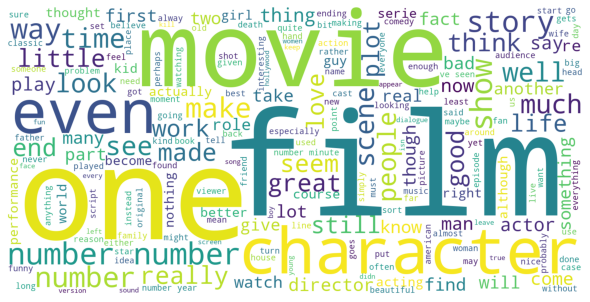

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

big_text = ''
for text in X_train:
    try:
        big_text += text
    except:
        pass

wordcloud = WordCloud(width = 1600, height = 800,
                      background_color ='white',
                      min_font_size = 10).generate(big_text) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

Vamos tentar ver mais alguns dados estatísticos como o número de avaliações positivas e negativas e a distribuições dessas análises relativa ao número de caracteres das mensagens

In [11]:
y_train.value_counts()

1    12461
0    12427
Name: positive, dtype: int64

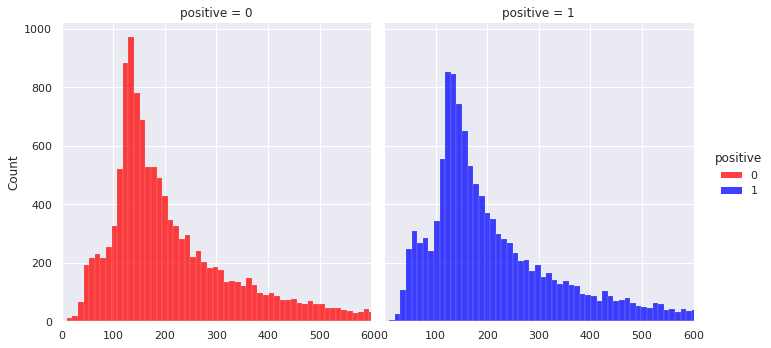

In [12]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 10)})

lengths = [len(re.findall(r'\w+', text)) for text in X_train]

colors = {
    0: 'red',  #Sentimento negativo
    1: 'blue', #Sentimento positivo
}

g = sns.displot(x=lengths, col=y_train, hue=y_train, palette=colors)
g.set(xlim=(0, 600))

Bom, como podemos ver existem mais ou menos o mesmo número de avaliações positivas e negativas no nosso dataset e elas também seguem praticamente a mesma distribuição.

# Tokenização e Doc2Vec

---

A ideia nessa parte é tokenizarmos nosso texto, ou seja, criar uma lista de palavras para cada um dos nossos textos e depois aplicar o modelo pré-treinado de Doc2Vec, ele vai converter nossos textos para números e dessa forma iremos conseguir aplicar nossos dados em um modelo de machine learning; esses processos são chamados de Word Embedding

In [13]:
#Vamos tokenizar nosso texto, ou seja, torná-lo um vetor de palavras

X_train = X_train.apply(lambda x: x.split())
X_train[5] #Assim fica o texto como tokens

['this',
 'isn',
 't',
 'the',
 'comedic',
 'robin',
 'williams',
 'nor',
 'is',
 'it',
 'the',
 'quirky',
 'insane',
 'robin',
 'williams',
 'of',
 'recent',
 'thriller',
 'fame',
 'this',
 'is',
 'a',
 'hybrid',
 'of',
 'the',
 'classic',
 'drama',
 'without',
 'over',
 'dramatization',
 'mixed',
 'with',
 'robin',
 's',
 'new',
 'love',
 'of',
 'the',
 'thriller',
 'but',
 'this',
 'isn',
 't',
 'a',
 'thriller',
 'per',
 'se',
 'this',
 'is',
 'more',
 'a',
 'mystery',
 'suspense',
 'vehicle',
 'through',
 'which',
 'williams',
 'attempts',
 'to',
 'locate',
 'a',
 'sick',
 'boy',
 'and',
 'his',
 'keeper',
 'also',
 'starring',
 'sandra',
 'oh',
 'and',
 'rory',
 'culkin',
 'this',
 'suspense',
 'drama',
 'plays',
 'pretty',
 'much',
 'like',
 'a',
 'news',
 'report',
 'until',
 'william',
 's',
 'character',
 'gets',
 'close',
 'to',
 'achieving',
 'his',
 'goal',
 'i',
 'must',
 'say',
 'that',
 'i',
 'was',
 'highly',
 'entertained',
 'though',
 'this',
 'movie',
 'fails',
 'to

Vamos agora aplicar a função de Doc2Vec também disponibilizada no moodle para os alunos.

In [14]:
from gensim.models.doc2vec import Doc2Vec

#Instanciando Doc2Vec
D2V = Doc2Vec.load('doc2vec')

def embedding(text, model, normalize=False): 
    model.random.seed(42)

    #Word2Vec
    x = model.infer_vector(text, steps=25)
    
    if normalize:
        return (x/np.sqrt(x@x))
    else:
        return (x)

In [15]:
#Aplicando o Word2Vec no nossos dados

X_train = X_train.to_list()
X_train = [embedding(text, D2V) for text in X_train] 
X_train = np.array(X_train)
X_train[5] #Nosso mesmo texto como ficou agora (em números)

array([-0.12112503, -0.66567445, -0.44296318, -0.6244586 , -1.2597122 ,
       -0.5241138 , -0.26518935,  0.14014487,  0.15607394, -1.9484546 ,
       -0.65840703,  0.16582713,  0.06669427,  0.2845399 ,  0.640564  ,
        0.48413914,  0.7339431 , -0.17255077, -0.13925746, -0.97216815,
        0.14360139,  1.0384549 , -0.54524535, -0.3371796 , -0.36696056,
       -0.04025301, -0.2055413 ,  0.20872127, -1.1937075 ,  0.9213505 ,
        1.1443474 , -0.22856976, -0.9847932 ,  1.3196887 , -0.15801166,
        0.15638252, -0.48906842, -0.42981422,  0.43535733, -0.35452008,
        0.5947334 , -0.195074  ,  0.3223219 ,  0.96399283,  0.5729398 ,
       -0.414798  ,  0.6772822 ,  0.27796292,  0.44072178, -0.4307452 ],
      dtype=float32)

Vamos agora aplicar nossas alterações de pré-processamento nos conjuntos de teste e validação e na próxima seção aplicar alguns modelos de machine learning.

In [16]:
def clean_data(data):
    data = data.apply(clean_text)
    data = data.apply(lambda x: x.split())
    data = data.to_list()
    data = [embedding(text, D2V) for text in data] 
    data = np.array(data)
    return data

In [17]:
#Carregando os outros dados
test = pd.read_csv('test.csv')

#Separando o teste e aplicando o processo de limpeza
X_test = clean_data(test['review'])
y_test = test['positive']

# Modelos:

---

Vamos agora nessa última parte por em prática os modelos pedidos pelo professor, dessa forma vamos aplicar então 3 redes neurais, sendo duas utilizando a biblioteca do scikit-learn e a última implementaçãoem tensorflow/keras (baseada no Tuned Model, disponível para todos pelo monitor), também é possível adicionarmos outro modelo como regressão logística e ver como ele performa

In [18]:
# Função para colocar alguns resultados de output

def result(model, model_name):
    print('########## RESULTADOS ##########')
    print()
    print(model_name)
    print()
    print('Melhores parâmetros:', model.best_params_)
    print()
    print('Melhor score:', model.best_score_)

In [19]:
#Importando algumas bibliotecas

import random

from scipy.stats import loguniform as sp_loguniform
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense
from tensorflow.python.framework import ops
from tensorflow.keras.callbacks import EarlyStopping

## Multilayer Perceptron - 1 Hidden Layer: Scikit-Learn

In [20]:
# Multilayer Perceptron com 1 camada escondida
parameter_space = {
    "hidden_layer_sizes": [(2 ** i) for i in np.arange(5, 12)],
    'alpha': sp_loguniform(0.000001, 0.1),
    'learning_rate': ['constant','adaptive'],
}

MLP_1Layer = MLPClassifier(random_state=12, early_stopping=True)

Grid_MLP_1Layer = RandomizedSearchCV(
                        MLP_1Layer, 
                        parameter_space, 
                        scoring='roc_auc',
                        n_iter=25, cv=2, n_jobs=-1, 
                        random_state=12, verbose=2
                        )

Search_MLP_1Layer = Grid_MLP_1Layer.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


In [21]:
result(Search_MLP_1Layer, 'MLP - 1 Hidden Layer')

########## RESULTADOS ##########

MLP - 1 Hidden Layer

Melhores parâmetros: {'alpha': 0.00018052695510905757, 'hidden_layer_sizes': 2048, 'learning_rate': 'adaptive'}

Melhor score: 0.8908338437212413


## Multilayer Perceptron - 2 Hidden Layers: Scikit-Learn

In [22]:
# Multilayer Perceptron com 2 camada escondida
parameter_space = {

    'hidden_layer_sizes': [(2 ** i, 2 ** j) for j in np.arange(5, 12) for i in np.arange(5, 12)],
    'alpha': sp_loguniform(0.000001, 0.1),
    'learning_rate': ['constant','adaptive'],
}

MLP_2Layer = MLPClassifier(random_state=12, early_stopping=True)

Grid_MLP_2Layer = RandomizedSearchCV(
                        MLP_1Layer, 
                        parameter_space,
                        scoring='roc_auc',
                        n_iter=25, cv=2, n_jobs=-1,
                        random_state=12, verbose=2,
                        )

Search_MLP_2Layer = Grid_MLP_2Layer.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.8min finished


In [23]:
result(Search_MLP_2Layer, 'MLP - 2 Hidden Layer')

########## RESULTADOS ##########

MLP - 2 Hidden Layer

Melhores parâmetros: {'alpha': 0.04794672993969796, 'hidden_layer_sizes': (2048, 128), 'learning_rate': 'adaptive'}

Melhor score: 0.8915966450907008


## Rede Neural - 2 Hidden Layers: Tensorflow

In [24]:
n_features = X_train.shape[1]
n_iter = 100

In [25]:
def create_model(neurons=(10,10), reg=(.001, .001)):
    
    #Resetando os grafos da rede
    ops.reset_default_graph()
    
    #Criando modelo
    model = Sequential()

    #Primeira camada
    model.add(Dense(
        neurons[0],
        input_shape = (n_features,),
        activation = "relu", 
        kernel_regularizer = regularizers.l1_l2(l1=reg[0], l2=reg[1]), 
        bias_regularizer = regularizers.l1_l2(l1=reg[0], l2=reg[1]),
    ))

    #Segunda camada
    model.add(Dense(
        neurons[1],
        activation = "relu", 
        kernel_regularizer = regularizers.l1_l2(l1=reg[0], l2=reg[1]), 
        bias_regularizer = regularizers.l1_l2(l1=reg[0], l2=reg[1])
    ))


    #Camada de output
    model.add(Dense(
        1,
        activation = "sigmoid", 
        kernel_regularizer = regularizers.l1_l2(l1=reg[0], l2=reg[1]), 
        bias_regularizer = regularizers.l1_l2(l1=reg[0], l2=reg[1])
    ))
    
    #Compilando
    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = [tf.keras.metrics.AUC()]
    )

    return model

In [26]:
#Inicializando

neurons = []
reg = []

#Sorteando valores
for i in range(n_iter):
    h1 = random.randrange(25, 100, 5)
    h2 = random.randrange(20, h1, 5)

    neurons.append((h1, h2))
    
    l1 = random.choice([0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    l2 = random.choice([0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

    reg.append((l1, l2))
    
#DataFrame com hiperparâmetros
hyper = {
        "neurons": neurons, 
         "reg": reg, 
         "epochs": n_iter*[None], 
         "auc": n_iter*[None],
}

hyper = pd.DataFrame(hyper)
hyper = hyper[["neurons", "reg", "epochs", "auc"]]

hyper.head()

,neurons,reg,epochs,auc
0,"(55, 30)","(0.0001, 0.0001)",None,None
1,"(40, 25)","(0.0001, 0.1)",None,None
2,"(30, 25)","(0.0001, 0.1)",None,None
3,"(35, 20)","(0.01, 0.001)",None,None
4,"(50, 20)","(0, 1e-05)",None,None


In [27]:
for j in range(n_iter):
    model = create_model(hyper.loc[j, "neurons"], hyper.loc[j,"reg"])
    
    es = EarlyStopping(monitor="val_auc", patience=10)
    
    history = model.fit(
                        X_train, y_train, 
                        validation_data = (X_test, y_test),
                        epochs=50, 
                        batch_size=120, 
                        shuffle=True, 
                        verbose=False,
                        callbacks=[es],
                )
    
    hyper.loc[j,"epochs"] = len(history.history["val_auc"])
    hyper.loc[j,"auc"] = history.history["val_auc"][-1]

    # Progresso
    if (j + 1) % int(n_iter/10) == 0:
        print('{:.2f}% concluded.'.format(100*(j + 1)/n_iter))
    else: 
        pass

10.00% concluded.
20.00% concluded.
30.00% concluded.
40.00% concluded.
50.00% concluded.
60.00% concluded.
70.00% concluded.
80.00% concluded.
90.00% concluded.
100.00% concluded.


In [28]:
hyper = hyper.iloc[np.argsort(hyper.loc[:,"auc"]),:]
hyper.tail(10)

,neurons,reg,epochs,auc
69,"(50, 35)","(1e-05, 0.0001)",11,0.892836
8,"(30, 20)","(1e-06, 0.0001)",11,0.892856
14,"(85, 80)","(0.0001, 1e-05)",11,0.893073
87,"(50, 30)","(0.0001, 0.001)",11,0.893098
52,"(45, 30)","(1e-06, 0)",11,0.893193
75,"(70, 25)","(1e-05, 0.001)",11,0.893588
21,"(70, 30)","(0.0001, 1e-05)",11,0.893704
0,"(55, 30)","(0.0001, 0.0001)",11,0.893945
84,"(80, 20)","(0, 0.001)",11,0.893962
28,"(95, 80)","(0, 0.001)",11,0.894092


In [29]:
#Melhores hiperparâmetros
neurons = hyper.iloc[-1, 0]
reg = hyper.iloc[-1, 1]
epochs = hyper.iloc[-1, 2]

#Criando o modelo com os melhores parâmetros
NN_2Layers = create_model(neurons, reg)

#Treino
NN_2Layers.fit(
    X_train, y_train,
    validation_split = 0,
    epochs = epochs,
    batch_size = 120,
    shuffle = True,
    verbose = True,
)

Epoch 1/11
208/208 [==============================] - 0s 2ms/step - loss: 0.5817 - auc: 0.8691
Epoch 2/11
208/208 [==============================] - 1s 2ms/step - loss: 0.4998 - auc: 0.8933
Epoch 3/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4707 - auc: 0.8980
Epoch 4/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4537 - auc: 0.9007
Epoch 5/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4435 - auc: 0.9020
Epoch 6/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4346 - auc: 0.9040
Epoch 7/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4274 - auc: 0.9061
Epoch 8/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4230 - auc: 0.9071
Epoch 9/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4188 - auc: 0.9085
Epoch 10/11
208/208 [==============================] - 0s 2ms/step - loss: 0.4166 - auc: 0.9092
Epoch 11/11
208/208 [============================

## Regressão Logística

In [30]:
from sklearn.linear_model import LogisticRegression

# Hiperparâmetros
parameter_space = dict(
    C = np.linspace(0, 10, 100),
    penalty = ['l2', 'l1'],
)


# Instanciândo o modelo de regressão logística
Logistic = LogisticRegression(
                solver = 'liblinear',
                random_state = 12,
            )

Grid_Logistic = RandomizedSearchCV(
                    Logistic,
                    parameter_space, 
                    scoring='roc_auc',
                    n_iter=50, cv=2, n_jobs=-1, 
                    random_state=0, verbose=2
                    )

Search_Logistic = Grid_Logistic.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.9s finished


In [31]:
result(Search_Logistic, 'Logistic Regression')

########## RESULTADOS ##########

Logistic Regression

Melhores parâmetros: {'penalty': 'l2', 'C': 0.20202020202020202}

Melhor score: 0.8850776175992903


# Comparando os Modelos:

Nessa parte vamos aplicar os 4 modelos treinados que temos no nosso conjunto de dados de teste e assim poderemos ter uma comparação de como eles estão performando e, assim escolher o melhor modelo para essa tarefa de análise de sentimentos.

In [32]:
models = [
          'MLP 1 Layer (Scikit)',
          'MLP 2 Layer (Scikit)',
          'NN  2 Layer (Tensorflow)',
          'Logistic Regression',
]

AUC = [
       roc_auc_score(y_test, Search_MLP_1Layer.predict_proba(X_test)[:,1]),
       roc_auc_score(y_test, Search_MLP_2Layer.predict_proba(X_test)[:,1]),
       roc_auc_score(y_test, NN_2Layers.predict(X_test).squeeze()),
       roc_auc_score(y_test, Search_Logistic.predict_proba(X_test)[:,1]),
]

scores = {
    'Modelos' : models,
    'AUC' : AUC,
}

scores_df = pd.DataFrame(scores)
scores_df.head()

,Modelos,AUC
0,MLP 1 Layer (Scikit),0.894233
1,MLP 2 Layer (Scikit),0.894769
2,NN 2 Layer (Tensorflow),0.893029
3,Logistic Regression,0.883523


Dava para olhar na mão, mas vamos fazer uma linha para achar o melhor modelo

In [33]:
scores_df.loc[scores_df['AUC'] == scores_df['AUC'].max()]

,Modelos,AUC
1,MLP 2 Layer (Scikit),0.894769


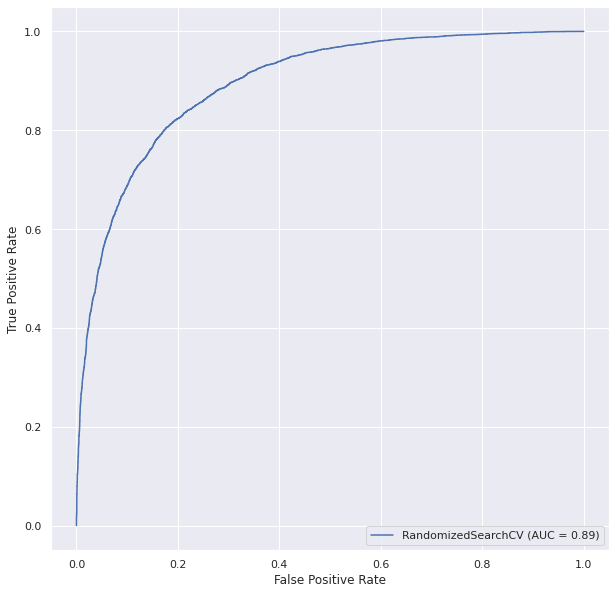

In [34]:
from sklearn.metrics import plot_roc_curve

#Plottando curva ROC
plot_roc_curve(Search_MLP_2Layer, X_test, y_test)

# Submissão

In [35]:
#Carregando os dados de validação
validation = pd.read_csv('validation.csv')

#Passando o processo de limpeza sobre esses dados
X_validation = clean_data(validation['review'])

#Predição
y_prediction = Search_MLP_2Layer.predict_proba(X_validation)[:,1]

#Criando submissão
submission = {'positive': y_prediction}
submission = pd.DataFrame(submission)
submission.to_csv("submission.csv", index = True, index_label = 'Id')